In [110]:
#settings
ROTATE_IMAGE = False

PLOT_UNIQUE_INTENSITIES = False
PLOT_IMAGE_INITIAL = True
PLOT_NORMALISED_HIST = True

CLIP_HIST_DATA = True

PIXELSTRUEUMFALSE = True

NORMALISE_ALL = False

In [111]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, curve_fit, minimize_scalar
from scipy import signal
from scipy.special import spherical_jn
from mpl_toolkits.mplot3d import Axes3D

paths to image source files 

In [112]:
source_list = [
    r"C:\Users\GAdmin\Desktop\srp\Hemanya and Sujen\speckle pictures june 13\with iris\001.csv",
    # r"C:\Users\GAdmin\Desktop\srp\Hemanya and Sujen\speckle pictures june 13\with iris\002.csv",
    # r"C:\Users\GAdmin\Desktop\srp\Hemanya and Sujen\speckle pictures june 13\with iris\003.csv",
    # r"C:\Users\GAdmin\Desktop\srp\Hemanya and Sujen\speckle pictures june 13\with iris\004.csv",
    # r"C:\Users\GAdmin\Desktop\srp\Hemanya and Sujen\speckle pictures june 13\with iris\005.csv"
]

In [113]:
pic_list = []

def get_pics(source_list):
    for source in source_list:
        data = pd.read_csv(source, header=None, delimiter=r"\s+").to_numpy()
        pic_list.append(data)

    return pic_list

pic_list = get_pics(source_list)

In [114]:
#camera stuff
sensor_size = pic_list[0].shape
print(sensor_size)

#rotational transform of matrix to compensate for tilt of lens -- deprecated
if ROTATE_IMAGE:
    from skimage.transform import rotate
    rotation_angle = -30
    im_matrix_4_rotated = rotate(im_matrix_4, rotation_angle)
    plt.imshow(im_matrix_4)
    plt.show()
    plt.imshow(im_matrix_4_rotated)

(816, 624)


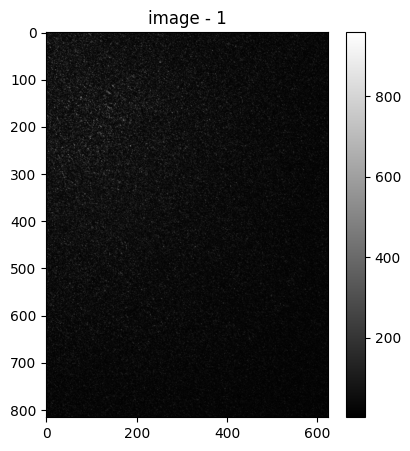

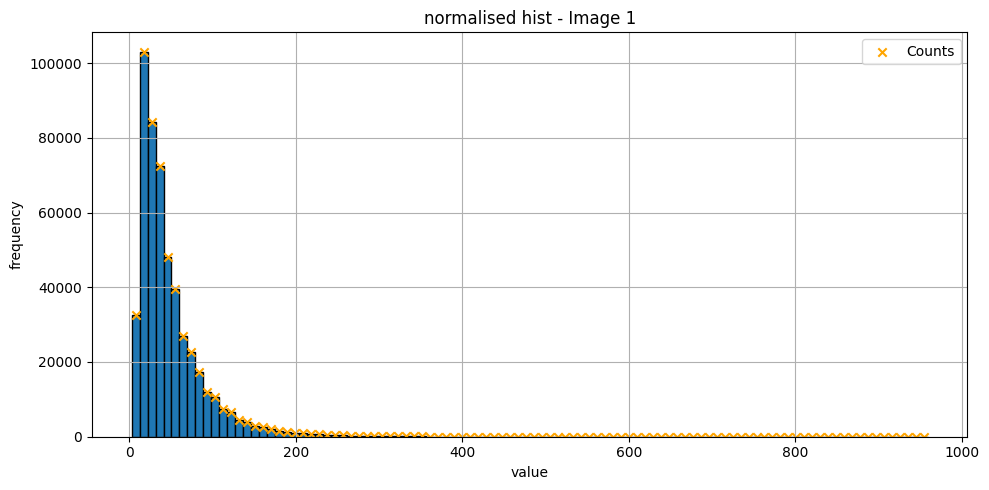

In [115]:
#plot images, hist, hist-normalised for all pictures
def plot_images_and_histograms(pic_list):
    for i, im_matrix in enumerate(pic_list):

        #image
        if PLOT_IMAGE_INITIAL:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            im = plt.imshow(im_matrix, cmap='gray', aspect='auto')
            plt.title(f"image - {i+1}")
            plt.colorbar(im)

        #hist
        if PLOT_UNIQUE_INTENSITIES:
            unique_intensities, counts = np.unique(im_matrix.flatten(), return_counts=True)
            plt.subplot(1, 2, 2)
            plt.scatter(unique_intensities, counts, s=2)
            plt.title(f"hist - Image {i+1}")
            plt.xlabel("value")
            plt.ylabel("frequency")
            plt.grid(True)
            plt.show()

        #hist-normalised
        if PLOT_NORMALISED_HIST:
            counts, bins = np.histogram(im_matrix, bins=100)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            plt.figure(figsize=(10, 5))

            if NORMALISE_ALL:
                counts = counts / counts.max()

            plt.bar(bin_centers, counts, width=np.diff(bins), align='center', edgecolor='black')
            plt.title(f"normalised hist - Image {i+1}")
            plt.xlabel("value")
            plt.ylabel("frequency")
            plt.grid(True)
            plt.scatter(bin_centers, counts, c='orange', marker='x', label='Counts')
            plt.legend()
            plt.tight_layout()
            plt.show()

plot_images_and_histograms(pic_list)

below - probability density function on the intensity of points. will extract $\bar{I}$ from fitting this equation
$$
p_I(I)= \frac{1}{\bar{I}}\cdot e^{-\frac{I}{\bar{I}}}
$$

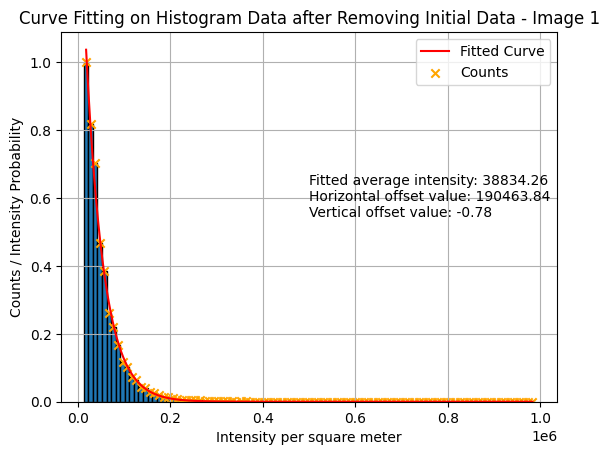

In [116]:
#pdf intensity
def intensity_probability_curve(x_o, a, b, c):
    return (1/(a)) * np.exp(-(x_o - b) / (a) + c)

def curve_fitting_pics(pic_list):
    highest_intensity_recorded = 80 * 10**-6
    area_of_pixel = 8.1 * 10**-11
    
    for i, im_matrix in enumerate(pic_list):
        #normalise intensity to highest value recorded
        highest_pixel_density = np.max(im_matrix)
        normalisation_factor = (highest_intensity_recorded / highest_pixel_density) * 1 / area_of_pixel

        #binning
        counts_hist, bins = np.histogram(im_matrix, bins=100)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bin_centers_normalised = bin_centers * normalisation_factor

        #fitting
        fitted_parameters, cov = curve_fit(intensity_probability_curve, bin_centers, counts_hist / counts_hist.max(), p0=[174, 159, 4.11])
        a, b, c = fitted_parameters

        large_range_of_X_values = np.arange(0, np.max(bin_centers), 0.1)
        generated_y_values = intensity_probability_curve(large_range_of_X_values, a, b, c)
        

        if not CLIP_HIST_DATA:
            #plot with fit, initial data, normalised
            plt.subplot(1, 2, 2)
            plt.bar(bin_centers_normalised, counts_hist / counts_hist.max(), width=np.diff(bins) * normalisation_factor, align='center', edgecolor='black')
            plt.plot(large_range_of_X_values * normalisation_factor, generated_y_values, label='Fitted Curve')
            plt.scatter(bin_centers_normalised, counts_hist / counts_hist.max(), c='orange', marker='x', label='Counts')
            plt.xlabel('Intensity per square meter')
            plt.ylabel('Counts / Intensity Probability')
            plt.title(f'Curve Fitting on Histogram Data - Image {i+1}')
            plt.text(0.5, 0.5, f"Fitted average intensity: {np.round(a * normalisation_factor, 2)}\nHorizontal offset value: {np.round(b * normalisation_factor, 2)}\nVertical offset value: {np.round(c, 2)}", transform=plt.gca().transAxes)
            plt.legend()
            plt.grid(True)
            plt.show()

        else:
            #clip points less than max
            position_of_largest_value = np.argmax(counts_hist)
            counts_new = np.delete(counts_hist, range(0, position_of_largest_value))
            bin_centers_new = np.delete(bin_centers, range(0, position_of_largest_value))

            #second curve fitting without initial data points
            fitted_parameters_new, cov_new = curve_fit(intensity_probability_curve, bin_centers_new, counts_new / counts_hist.max(), p0=[170, -800, 4.0])
            A, B, C = fitted_parameters_new

            #y-values for the new fitted curve
            large_range_of_X_values_new = np.arange(bin_centers_new[0], np.max(bin_centers_new), 0.1)
            generated_y_values_new = intensity_probability_curve(large_range_of_X_values_new, A, B, C)

            #new normalized histogram with new curve fit
            plt.bar(bin_centers_new * normalisation_factor, counts_new / counts_hist.max(), width=np.diff(bins[position_of_largest_value:]) * normalisation_factor, align='center', edgecolor='black')
            plt.plot(large_range_of_X_values_new * normalisation_factor, generated_y_values_new, label='Fitted Curve', c='red')
            plt.scatter(bin_centers_new * normalisation_factor, counts_new / counts_hist.max(), c='orange', marker='x', label='Counts')
            plt.xlabel('Intensity per square meter')
            plt.ylabel('Counts / Intensity Probability')
            plt.title(f'Curve Fitting on Histogram Data after Removing Initial Data - Image {i+1}')
            plt.text(0.5, 0.5, f"Fitted average intensity: {np.round(A * normalisation_factor, 2)}\nHorizontal offset value: {np.round(B * normalisation_factor, 2)}\nVertical offset value: {np.round(C, 2)}", transform=plt.gca().transAxes)
            plt.legend()
            plt.grid(True)
            plt.show()

curve_fitting_pics(pic_list)

The Bessel function which we will fit onto the data.
$$
\Gamma_1(r)= \bar{I}^2 \left[ 1 + \left|\left(2\frac{J_1\frac{\pi D r}{\lambda z}}{\frac{\pi D r}{\lambda z}}\right)\right|^2 \right]
$$

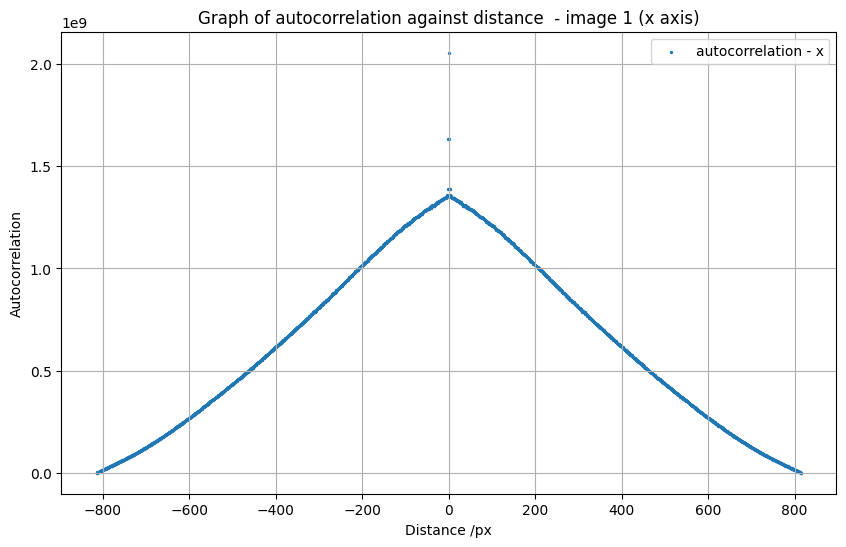

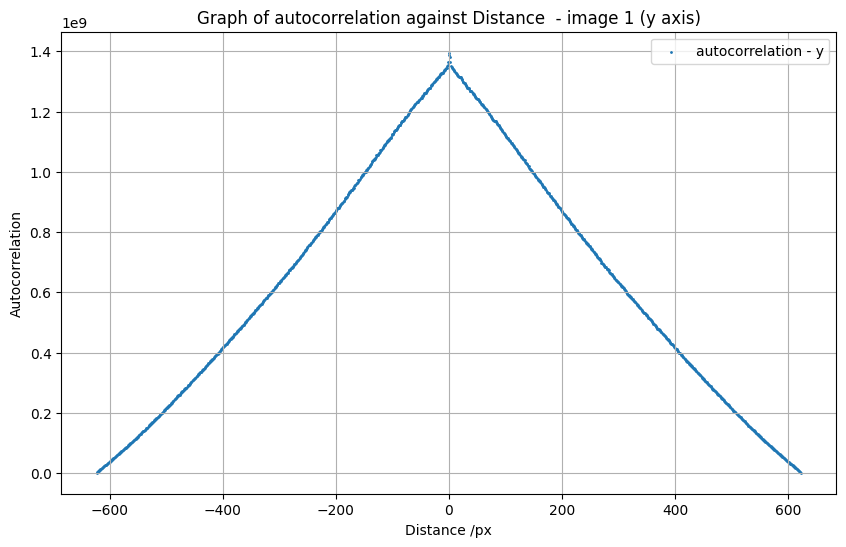

C:\Users\GAdmin\AppData\Local\Temp\ipykernel_9632\4010447324.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max_value_autocorrelation_pos = int(max_value_autocorrelation_pos[0])


62.68158263061131


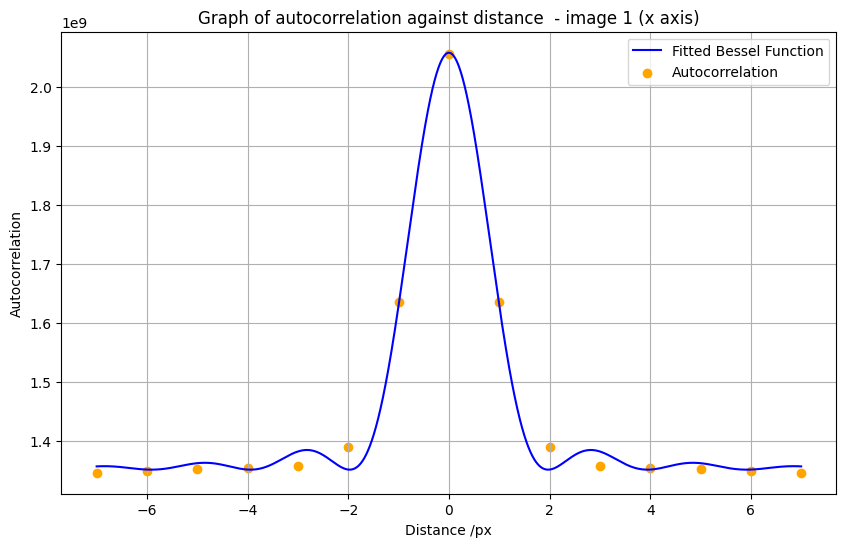

autocorrelation length:  3.944
FWHM:  1.7499999999959215


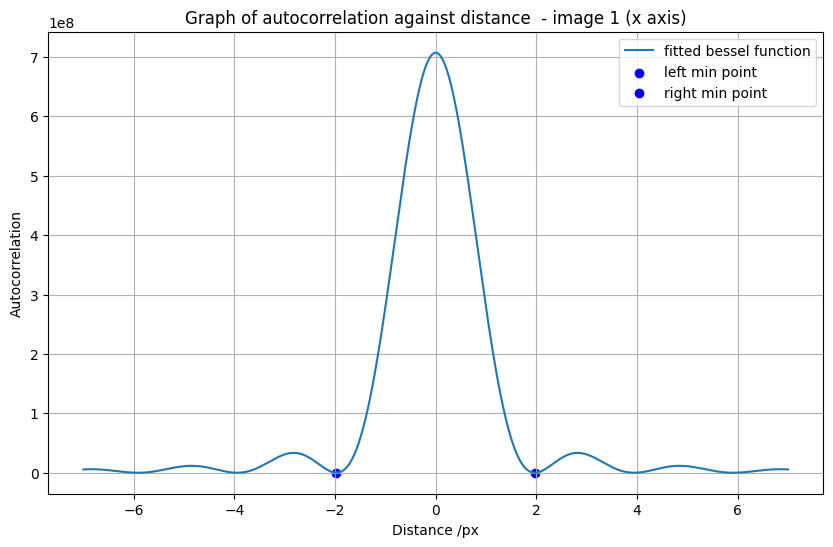

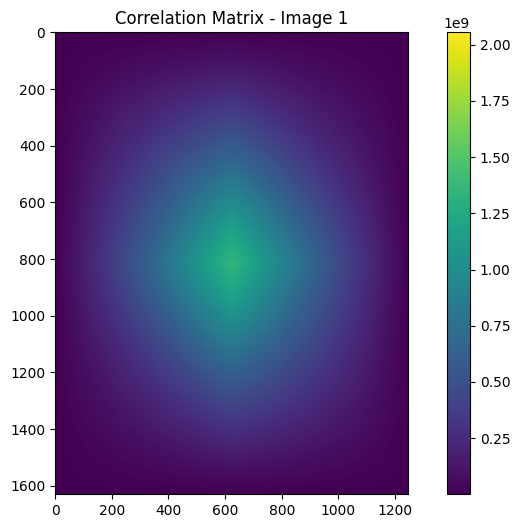

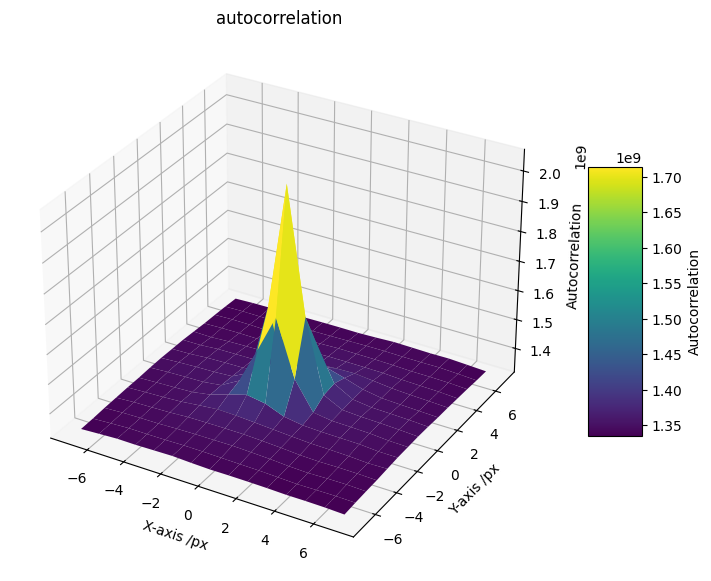

autocorrelation length: image: 1 is: 15.749999999963293 um


In [118]:
#vertical coeff offset - account for stray light
def bessel_function(distance_dist, I_ave, B, A, C):
    return (I_ave**2) * (1 + ((2 * B * spherical_jn(0, A * distance_dist)) / A)**2) + C

def correlate(pic_list):
    for i, im_matrix in enumerate(pic_list):

        #compute autocorrelation
        correlation = signal.correlate(im_matrix, im_matrix)
        correlation_dist_x = signal.correlation_lags(len(im_matrix), len(im_matrix))
        correlation_dist_y = signal.correlation_lags(624, 624)
        L, B = np.shape(correlation)
        
        #finding midpoint
        correlation_plotted_X = correlation[::1, int(((B + 1) / 2) - 1)]
        correlation_plotted_y = correlation[int(((L + 1) / 2) + 1), ::1]

        if NORMALISE_ALL:
            correlation_plotted_X /= np.max(correlation_plotted_X)

            #theres some weird ahh outlier messing up the normalised plot - its not there if you dont normalise it??
            correlation_plotted_X = np.delete(correlation_plotted_X, np.where(correlation_plotted_X == 0))
            correlation_plotted_y /= np.max(correlation_plotted_y)

        #convert the correlation lags (correlation distances to micrometers from pixels)
        unit = None
        if PIXELSTRUEUMFALSE:
            mult = 1
            unit = "px"
        else:
            mult = 9
            unit = "um"

        correlation_dist_x = correlation_dist_x * mult
        correlation_dist_y = correlation_dist_y * mult 

        
        # Plot autocorrelation in the x and y-axis
        plt.figure(figsize=(10, 6))
        plt.scatter(correlation_dist_x, correlation_plotted_X, label='autocorrelation - x', s=2)
        plt.grid(True); plt.legend(); plt.ylabel("Autocorrelation")
        
        if PIXELSTRUEUMFALSE:
            plt.xlabel("Distance /px")
        else:
            plt.xlabel("Distance: /um")
        plt.title(f"Graph of autocorrelation against distance  - image {i + 1} (x axis)")

        plt.figure(figsize=(10, 6))
        plt.scatter(correlation_dist_y, correlation_plotted_y, label='autocorrelation - y', s=1)
        plt.grid(True); plt.legend(); plt.ylabel("Autocorrelation")
        if PIXELSTRUEUMFALSE:
            plt.xlabel("Distance /px")
        else:
            plt.xlabel("Distance: /um")
        plt.title(f"Graph of autocorrelation against Distance  - image {i + 1} (y axis)"); plt.show()

        #modifying distance and autocorrelation arrays - finds the max value of autocorrelation function and clips from -7:8
        max_value_autocorrelation  = np.max(correlation_plotted_X)
        max_value_autocorrelation_pos = np.where(correlation_plotted_X == max_value_autocorrelation) 
        max_value_autocorrelation_pos = int(max_value_autocorrelation_pos[0])

        clip = 7
        correlation_plotted_X_fit = correlation_plotted_X[max_value_autocorrelation_pos - clip:max_value_autocorrelation_pos + (clip + 1)]
        correlation_dist_x_fit = correlation_dist_x[max_value_autocorrelation_pos - clip:max_value_autocorrelation_pos + (clip + 1)]

        #fit bessel func and plot
        p0 = [2.2449*10**2, 3.57615*10**2, -1.771, 8.623*10**9]
        Fitted_parameters_autocorrelation, _ = curve_fit(bessel_function, correlation_dist_x_fit, correlation_plotted_X_fit, p0=p0)
        I_ave, B, A, C = Fitted_parameters_autocorrelation
        print(I_ave)

        large_number_X_values_autocorrelation = np.arange(np.min(correlation_dist_x_fit), np.max(correlation_dist_x_fit), 0.0001)
        fitted_autocorrelation_values = bessel_function(large_number_X_values_autocorrelation, I_ave, B, A, C)

        plt.figure(figsize=(10, 6))
        plt.plot(large_number_X_values_autocorrelation, fitted_autocorrelation_values, c='blue', label='Fitted Bessel Function')
        plt.scatter(correlation_dist_x_fit, correlation_plotted_X_fit, c='orange', label='Autocorrelation')
        plt.grid(True); plt.legend(); plt.ylabel("Autocorrelation")
        if PIXELSTRUEUMFALSE:
            plt.xlabel("Distance /px")
        else:
            plt.xlabel("Distance: /um")
        plt.title(f"Graph of autocorrelation against distance  - image {i + 1} (x axis)"); plt.show()

        #extracting relevant parameters, adding y coeff offset to the bessel function (find fwhm)
        fitted_autocorrelation_values_analyse = fitted_autocorrelation_values - C
        max_value = np.max(fitted_autocorrelation_values_analyse)
        half_max_value = max_value/2
        tolerance = 1000000
        half_max_values = np.where(np.abs(fitted_autocorrelation_values_analyse - half_max_value) < tolerance)[0]
        half_max_value_neg = half_max_values[0]
        half_max_value_pos = half_max_values[len(half_max_values) - 1]

        #correlation length
        fwhm = large_number_X_values_autocorrelation[half_max_value_pos] - large_number_X_values_autocorrelation[half_max_value_neg]

        #minimum point - reminder (full width at 0 is the distance between the first set of minima)
        minimum_point_neg = minimize_scalar(lambda x: bessel_function(x, I_ave, B, A, C), bounds=(-3, 0))
        minimum_point_pos = minimize_scalar(lambda x: bessel_function(x, I_ave, B, A, C), bounds=(0, 3))
        fullwidth0 = np.round(minimum_point_pos.x - minimum_point_neg.x, 3)

        #final function with the measurements
        plt.figure(figsize=(10, 6))
        plt.plot(large_number_X_values_autocorrelation, fitted_autocorrelation_values_analyse, label='fitted bessel function')
        plt.scatter(minimum_point_pos.x, bessel_function(minimum_point_pos.x, I_ave, B, A, C) - C, label='left min point')
        plt.scatter(minimum_point_neg.x, bessel_function(minimum_point_neg.x, I_ave, B, A, C) - C, label='right min point')
        print("autocorrelation length: ", fullwidth0); print("FWHM: ", fwhm)
        plt.grid(True); plt.legend(); plt.ylabel("Autocorrelation")
        if PIXELSTRUEUMFALSE:
            plt.xlabel("Distance /px")
        else:
            plt.xlabel("Distance: /um")
        plt.title(f"Graph of autocorrelation against distance  - image {i + 1} (x axis)"); plt.show()

        #correlation matrix
        plt.figure(figsize=(10, 6))
        plt.imshow(correlation)
        plt.title(f"Correlation Matrix - Image {i + 1}")
        plt.colorbar() ;plt.show()

        #3d plot of overall autocorrelation
        correlation_dist_x = correlation_dist_x[len(correlation_dist_x) // 2 - clip: len(correlation_dist_x) // 2 + (clip + 1)]
        correlation_dist_y = correlation_dist_y[len(correlation_dist_y) // 2 - clip: len(correlation_dist_y) // 2 + (clip + 1)]

        center_y, center_x = correlation.shape[0] // 2, correlation.shape[1] // 2
        correlation = correlation[center_y - clip:center_y + clip + 1, 
                              center_x - clip:center_x + clip + 1]
            
        if NORMALISE_ALL:
            correlation = correlation / np.max(np.abs(correlation))

        X, Y = np.meshgrid(correlation_dist_x, correlation_dist_y)
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        surface = ax.plot_surface(X, Y, correlation.T, cmap='viridis', edgecolor='none')
        ax.set_title('autocorrelation')
        if PIXELSTRUEUMFALSE:
            ax.set_xlabel('X-axis /px')
            ax.set_ylabel('Y-axis /px')
        else:
            ax.set_xlabel('X-axis /um')
            ax.set_ylabel('Y-axis /um')
        ax.set_zlabel('Autocorrelation')
        fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5, label='Autocorrelation')
        plt.show()

        fwhm_um = fwhm * 9
        print("autocorrelation length: image:", i + 1, "is:", fwhm_um, "um")

correlate(pic_list)